# Example of using library code

So far, we only provide channelmap editing for the Neuropixels probe family, and only the 4-shank Neuropixels probe is tested, so the following example codes use the 4-shank Neuropixels probe as the targeting probe.

## Basic

In [ ]:
import numpy as np

from neurocarto.probe_npx import *

### Create an empty channelmap

In [ ]:
s = ChannelMap(24)
s

ChannelMap[4,2,640,384,0]

The above output printed the information of channelmap `s`, in the format `ChannelMap[S,C,R,H,E]`, where `S` is the number of total shanks, `C` is the number of total columns in a shank, `R` is the number of total rows in a shank, `H` is the number of total channels, and `E` is the number of selected electrodes.

For a valid channelmap, `H` and `E` should be equal.

### Load/Save a channelmap

`*.imro` (**im**ec **r**ead-**o**ut file) is the format of the Neuropixels channelmap used by 
[SpikeGLX](https://billkarsh.github.io/SpikeGLX/). 
[detail](https://billkarsh.github.io/SpikeGLX/help/imroTables/)

In [ ]:
# load channelmap from file
s = ChannelMap.from_imro('channelmap.imro')

In [ ]:
# save channelmap to file
s.save_imro('channelmap.imro')

Note that if `s` is incompleted, which means the number of selected electrodes `E` is not equals to the total channel number `H`, `save_imro` will raise an error.

We support read channelmap from different file format.

In [ ]:
_ = ChannelMap.from_meta('channelmap.meta') # from meta file from Spike outputs
_ = ChannelMap.parse('(24,384)(...)') # from raw imro table format

We support other output formats. The following code requires to install extra library (as optional dependency).

In [ ]:
#!pip install probeinterface
p = s.to_probe() # type: Probe
s = ChannelMap.from_probe(p)
p

Probe - IMEC - Neuropixels 2.0 - Four Shank - Prototype - 384ch - 1shanks

Or other channelmap data output formats.

In [ ]:
#!pip install pandas
s.to_pandas() # type: pd.Dataframe
# empty channels use -1

,shank,column,row,in_used,x,y
channel,,,,,,
0,0,0,0,True,0,0
1,0,1,0,True,32,0
2,0,0,1,True,0,15
3,0,1,1,True,32,15
4,0,0,2,True,0,30
...,...,...,...,...,...,...
379,0,1,141,True,32,2115
380,0,0,142,True,0,2130
381,0,1,142,True,32,2130


In [ ]:
#!pip install polars
s.to_polars() # type: pl.DataFrame
# empty channels use null

channel,shank,column,row,in_used,x,y
i64,i64,i64,i64,bool,i64,i64
0,0,0,0,true,0,0
1,0,1,0,true,32,0
2,0,0,1,true,0,15
3,0,1,1,true,32,15
4,0,0,2,true,0,30
5,0,1,2,true,32,30
6,0,0,3,true,0,45
7,0,1,3,true,32,45
8,0,0,4,true,0,60


### Select electrodes manually

Select an electrode as a readout channel

In [ ]:
s = ChannelMap(24)
e = s.add_electrode((0, 0, 0)) # select an electrode at shank 0, column 0 and row 9
e

Electrode[0,0,0]

The above output printed the information of an electrode in format `Electrode[S,C,R]`, where `S` is shank index, `C` in column index, and `R` is row index.

If a channel has been used, then you cannot select coorespond electrodes. A `ChannelHasUsedError` will be raised.

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')

try:
    s.add_electrode((0, 0, 0))
except ChannelHasUsedError as x:
    print(repr(x))
    print(x.electrode)

ChannelHasUsedError('Electrode[0,0,0]')
Electrode[0,0,0]


To ignore the selected electrode, you can use the `exist_ok` keyword in the `add_electrode` method.

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
e = s.add_electrode((0, 0, 0), exist_ok=True)
print(e)

Electrode[0,0,0]


It could still raises a `ChannelHasUsedError` if the newly selected electrode will violate the hardware restriction. In the Neuropixels case, it means both electrodes are shared same channel. `ChannelMap` does not allow electrode overwriting, so you need to remove the previous one and re-select the new one. 

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
e = None
try:
    s.add_electrode((1, 0, 0))
except ChannelHasUsedError as x:
    print(repr(x))
    s.del_electrode(x.electrode)
    e = s.add_electrode((1, 0, 0))
print(e)

ChannelHasUsedError('Electrode[0,0,144]')
Electrode[1,0,0]


### Access electrodes from a channelmap

Access the selected electrode via its channel ID.

In [2]:
s = ChannelMap.from_imro('channelmap.imro')
print(s.channels[0])
print(s.channels[0:3])

Electrode[0,0,0]
[Electrode[0,0,0], Electrode[0,1,0], Electrode[0,0,1]]


Access the selected electrodes via its position.

In [3]:
print(s.electrodes[0, 0, 0]) # shank, column, row
print(s.electrodes[0, 0, 0:3])

Electrode[0,0,0]
[Electrode[0,0,0], Electrode[0,0,1], Electrode[0,0,2]]


Both properties `channels` and `electrodes` are iterable, which they can be put in the `for` loop. Both yeild electrode in the same order. The difference is `channels` may yield `None`.

In [10]:
del s.channels[1] # remove an electrode
for c, e in enumerate(s.channels):
    print(c, e, end='; ')
    if c >= 3: print(); break;
for i, e in enumerate(s.electrodes):
    print(i, e, end='; ')
    if i >= 3: break;

0 Electrode[0,0,0]; 1 None; 2 Electrode[0,0,1]; 3 Electrode[0,1,1]; 
0 Electrode[0,0,0]; 1 Electrode[0,0,1]; 2 Electrode[0,1,1]; 3 Electrode[0,0,2]; 

### Set electrode’s parameters

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
print(s.channels[0].in_used, s.channels[1].in_used)

# one by one
s.channels[0].in_used = False
print(s.channels[0].in_used)

# by a reference
e = Electrode(0, 0, 0)
e.in_used = False
s.channels[:] = e # apply to all selected electrodes
print(s.channels[1].in_used)

True True
False
False


### Electrode positions

You can use properties `channel_pos_x`, `channel_pos_y`, and `channel_pos` to get electrodes position in um. The missing electrode will be filled with `nan`.

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
p = s.channel_pos # a (C, 2) position (um) array
print(p.shape)
p[:10, :]

(384, 2)


array([[ 0,  0],
       [32,  0],
       [ 0, 15],
       [32, 15],
       [ 0, 30],
       [32, 30],
       [ 0, 45],
       [32, 45],
       [ 0, 60],
       [32, 60]])

Besides above instance properties, we also provide two position functions for more options on return.

In [26]:
from neurocarto.probe_npx.npx import channel_coordinate, electrode_coordinate

c = channel_coordinate(s)
print('Array[int, E, (S, C, R)]', c.shape)
print(c[:4])

c = channel_coordinate(s, electrode_unit='xy')
print('Array[int, E, (X, Y)]', c.shape)
print(c[:4])

c = electrode_coordinate(s)
print('Array[int, E, (S, C, R)]', c.shape)
print(c[:4])

c = electrode_coordinate(s, electrode_unit='xy')
print('Array[int, E, (X, Y)]', c.shape)
print(c[:4])

Array[int, E, (S, C, R)] (384, 3)
[[ 0.  0.  0.]
 [nan nan nan]
 [ 0.  0.  1.]
 [ 0.  1.  1.]]
Array[int, E, (X, Y)] (384, 2)
[[ 0.  0.]
 [nan nan]
 [ 0. 15.]
 [32. 15.]]
Array[int, E, (S, C, R)] (5120, 3)
[[0 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 1]]
Array[int, E, (X, Y)] (5120, 2)
[[ 0  0]
 [32  0]
 [ 0 15]
 [32 15]]


## Plotting

In [17]:
import matplotlib
import matplotlib.pyplot as plt
from neurocarto.probe_npx import plot

%matplotlib inline
rc = matplotlib.rc_params_from_file('channelmap.matplotlibrc', fail_on_error=True, use_default_template=True)

plot a channelmap.

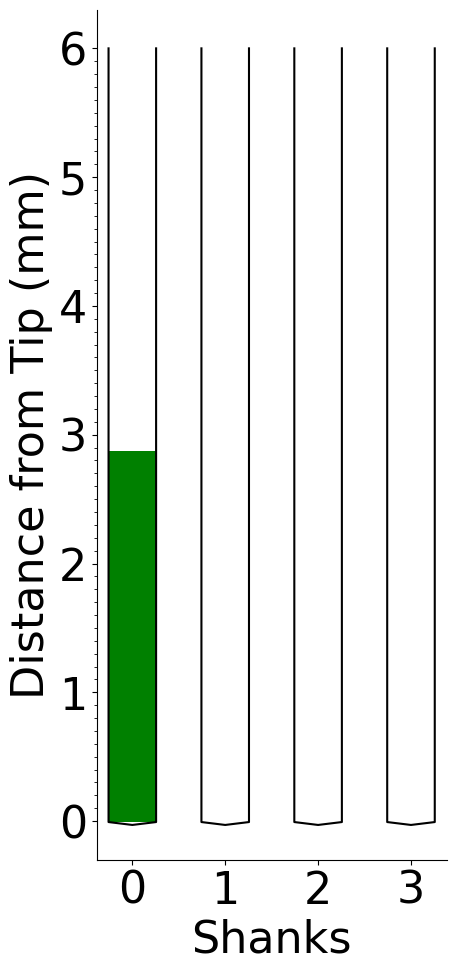

In [7]:
s = ChannelMap.from_imro('channelmap.imro')

with plt.rc_context(rc):
    fg, ax = plt.subplots()
    plot.plot_channelmap_block(ax, s, height=6, color='g', shank_width_scale=2)
    plot.plot_probe_shape(ax, s, height=6, color='k', label_axis=True, shank_width_scale=2)

plt.show()

plot a channelmap in other style.

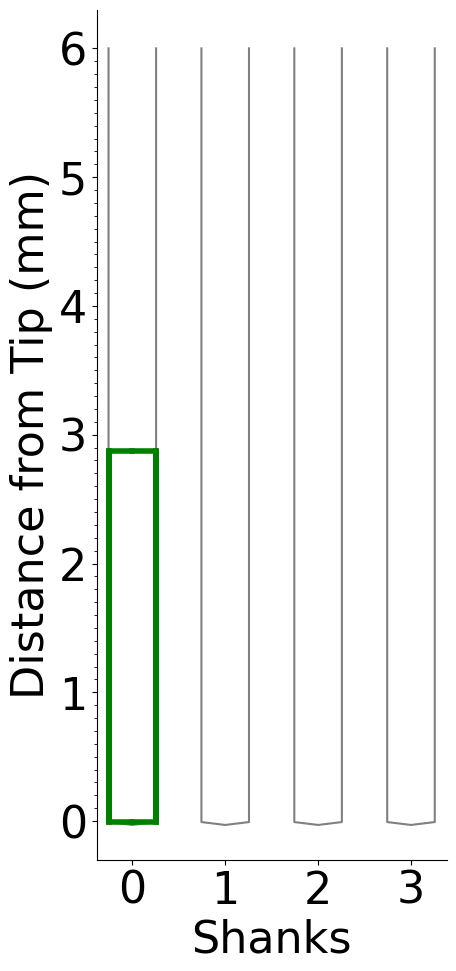

In [8]:
s = ChannelMap.from_imro('channelmap.imro')

with plt.rc_context(rc):
    fg, ax = plt.subplots()

    plot.plot_probe_shape(ax, s, height=6, color='gray', label_axis=True, shank_width_scale=2)
    plot.plot_channelmap_grid(ax, s, height=6, color='g', lw=4, shank_width_scale=2)


plt.show()

## Generate a Channelmap

We provide some builtin channelmaps.

### Block-based channelmap

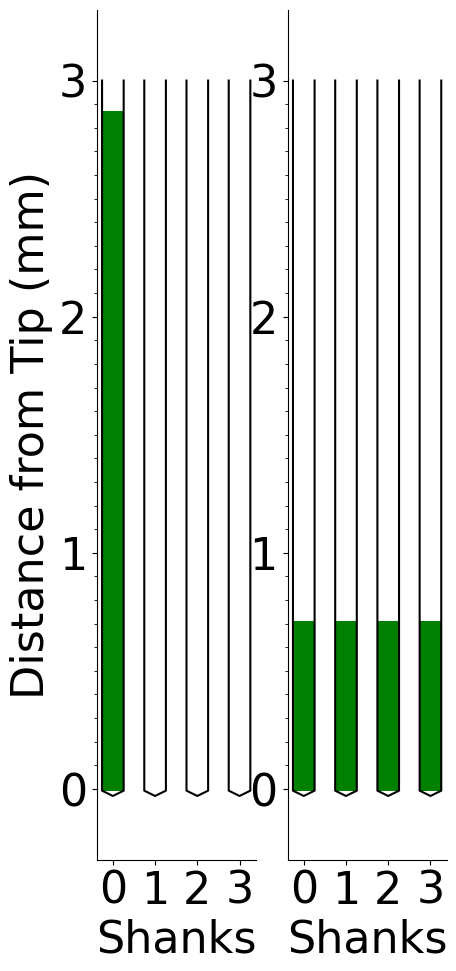

In [13]:
with plt.rc_context(rc):
    fg, ax = plt.subplots(1, 2)
    kwargs = dict(height=3, shank_width_scale=2)
    
    s = npx24_single_shank(0)
    plot.plot_channelmap_block(ax[0], s, color='g', **kwargs)
    plot.plot_probe_shape(ax[0], s, color='k', label_axis=True, **kwargs)
    
    s = npx24_stripe(0)
    plot.plot_channelmap_block(ax[1], s, color='g', **kwargs)
    plot.plot_probe_shape(ax[1], s, color='k', label_axis=True, **kwargs)
    ax[1].set_ylabel(None)
    
plt.show()

### Uniform channelmaps

All selected electrodes are distributed uniformly in a particular density.

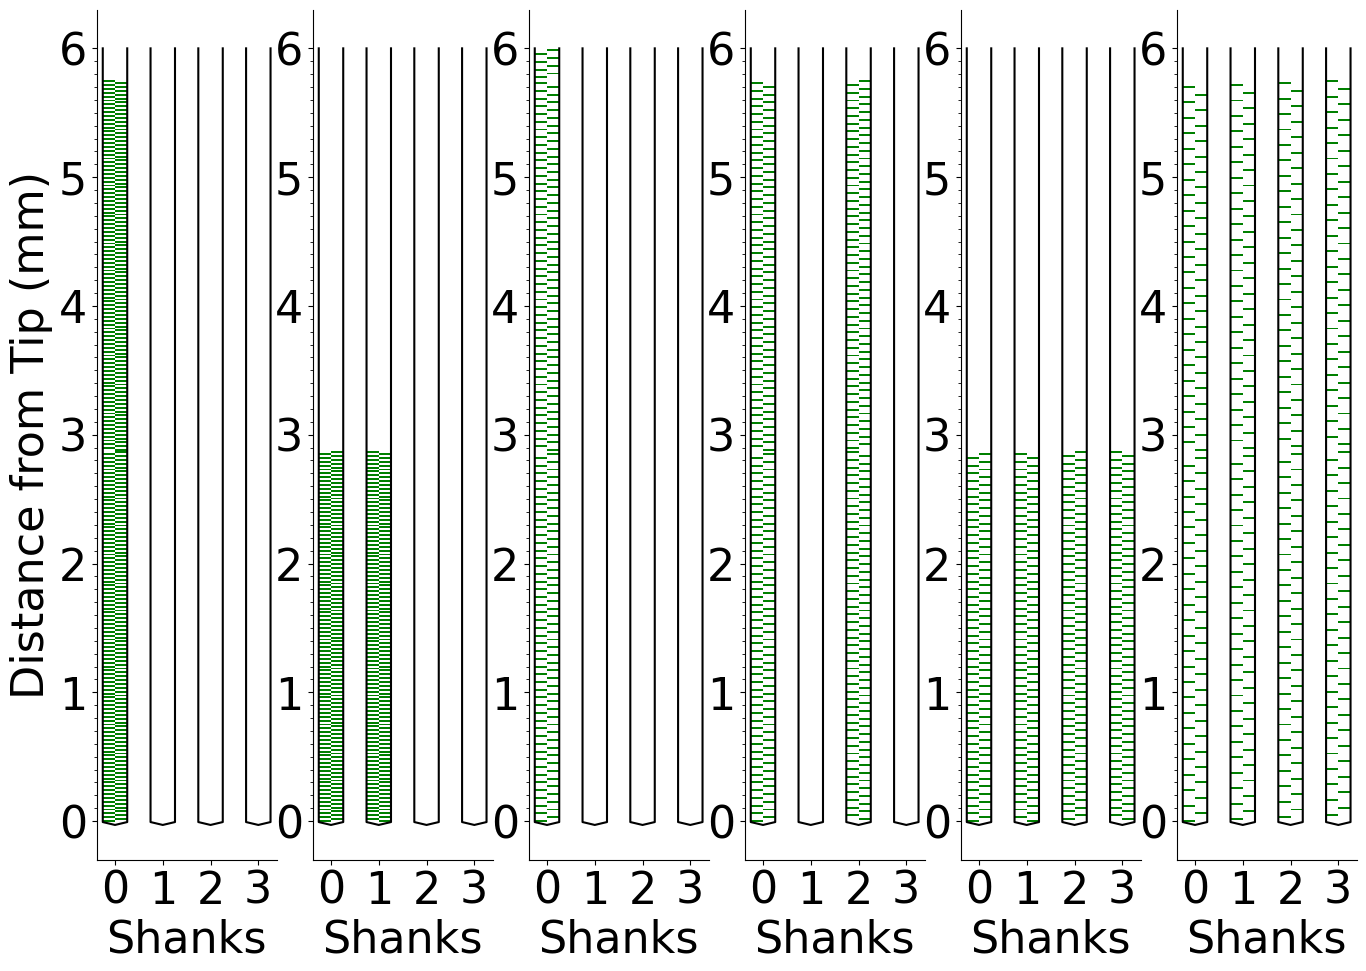

In [22]:
ss = [
    # 1/2
    npx24_half_density(shank=0),
    npx24_half_density(shank=(0, 1)),
    # 1/4
    sq := npx24_quarter_density(shank=0),
    npx24_quarter_density(shank=(0, 2)),
    npx24_quarter_density(None),
    # 1/8
    npx24_one_eighth_density()
]

with plt.rc_context(rc):
    fg, ax = plt.subplots(1, len(ss), figsize=(3 * len(ss), 10))
    kwargs = dict(height=6, shank_width_scale=2)
    
    for i, s in enumerate(ss):
        plot.plot_channelmap_block(ax[i], s, color='g', **kwargs)
        plot.plot_probe_shape(ax[i], s, color='k', label_axis=True, **kwargs)
        if i > 0: ax[i].set_ylabel(None)
    
plt.show()

Notice the the channelmap `sq` (the third map) is an incompleted channelmap, because its number of selected electrodes do not reach the number of required channels.

In [16]:
sq

ChannelMap[4,2,640,384,320]

## Generate a custom channelmap with a given blueprint

In [35]:
from neurocarto.probe_npx.desp import NpxProbeDesp, NpxElectrodeDesp

In [34]:
D = NpxProbeDesp()
C: ChannelMap = ChannelMap.from_imro('Fig3_example.imro')
Q: list[NpxElectrodeDesp] = D.load_blueprint('Fig3_example.blueprint.npy', C)

A blueprint `Q` is loaded from a file. It is not easy to make a new blueprint from zero. It is more easy to make a new one from the application.

### Electrode selection

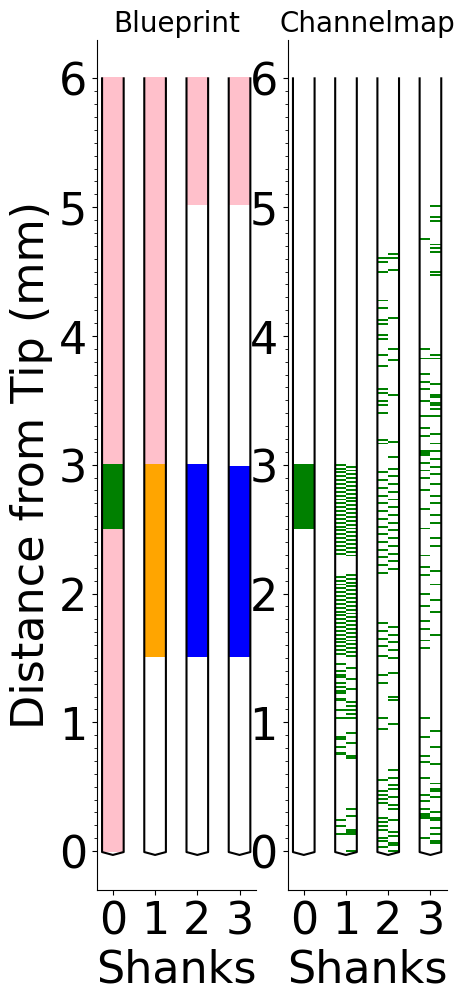

In [43]:
s = D.select_electrodes(C, Q)

with plt.rc_context(rc):
    fg, ax = plt.subplots(1, 2)
    kwargs = dict(height=6, shank_width_scale=2)
    
    plot.plot_category_area(ax[0], C.probe_type, Q, **kwargs)
    plot.plot_probe_shape(ax[0], C, color='k', label_axis=True, **kwargs)
    ax[0].set_title('Blueprint', fontdict=dict(fontsize=20))
    
    plot.plot_channelmap_block(ax[1], s, color='g', **kwargs)
    plot.plot_probe_shape(ax[1], s, color='k', label_axis=True, **kwargs)
    ax[1].set_ylabel(None)
    ax[1].set_title('Channelmap', fontdict=dict(fontsize=20))
    
plt.show()